#### importing

In [140]:
%matplotlib inline

import numpy as np
import pandas as pd
import re
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
plt.rcParams['figure.dpi']= 100

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import ExtraTreesClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.feature_selection import chi2

import nltk
from nltk.tokenize import TweetTokenizer
import string

from sklearn.model_selection import train_test_split

from sklearn.metrics import cohen_kappa_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


plt.style.use('seaborn-colorblind')

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_colwidth', 100)

In [ ]:
!pip install language-tool-python
!pip install g2p-en
!apt update
!apt install enchant --fix-missing
!apt install -qq enchant
!pip install pyenchant
import language_tool_python
from g2p_en import G2p
import enchant
tknzr = TweetTokenizer()
d = enchant.Dict("en_US")
g2p = G2p()


In [175]:
training_set  = pd.read_csv('training_set.csv', encoding = "ISO-8859-1")\
            .rename(columns={ 'essay_set': 'topic','domain1_score': 'target_score', 'domain2_score': 'topic2_target'})
training_set.sample()

,essay_id,topic,essay,rater1_domain1,rater2_domain1,target_score
161,162,4,I think that the author concludes the story with this paragraph by teaching Saeng how to be conf...,1,1,1


#### feature extraction funcs

In [176]:
def load_file(filename):
    dataset = pd.read_table(filename, header=0, sep=",", encoding="unicode_escape")
    
    essay_set1 = dataset.loc[dataset['essay_set'] == 1]
    essay_set3 = dataset.loc[dataset['essay_set'] == 3]
    essay_set4 = dataset.loc[dataset['essay_set'] == 4]
    essay_set5 = dataset.loc[dataset['essay_set'] == 5]
    essay_set6 = dataset.loc[dataset['essay_set'] == 6]
    essay_set7 = dataset.loc[dataset['essay_set'] == 7]
    return ([ essay_set1['essay'], essay_set3['essay'], essay_set4['essay'], essay_set5['essay'], essay_set6['essay'], essay_set7['essay'] ])

def word_tokenization(es):

    # for essay in essay_set:
    proper_pronouns = ['@ORGANIZATION', '@PEOPLE', '@LOCATION', '@DATE', '@CAPS', '@NUM', '@MONTH', '@YEAR', '@PERCENT', '@TIME', '@MONEY', '@QUANTITY', '@LANGUAGE']
    e_tokenize = tknzr.tokenize(es)
    bag_of_words = []
    for x in e_tokenize:
        if (x[:len(x)-1] in proper_pronouns) or (x in string.punctuation):
            pass
        else:
            bag_of_words.append(x.lower())

    # print(bag_of_words)

    # word-based tokenization
    word_tokens = {}
    token = 1
    for x in bag_of_words:
        if x in word_tokens.keys():
            pass
        else:
            word_tokens[x] = token
            token += 1

    return word_tokens
    
def vocabulary_check(word_tokens):

    # check for vocabulary errors
    total_words = len(word_tokens)
    correctness = 0
    correct = 0
    for x in word_tokens.keys():
        if (d.check(x) == True):
            correct = correct + 1

    misspelt = total_words - correct 
    return misspelt

def extract_feature_set4():
    words_count = []
    word_count = 0
    sentences_count = []
    unique_words_count = []

    essaysets = load_file("training_set.csv")
    for essayset in essaysets:
        for essay in essayset:
            length = len(essay.split())
            words_count.append(length)

            total_sentences = 0
            sentences = essay.split('.')
            for i in sentences:
                sentences[total_sentences] = sentences[total_sentences].split()
                total_sentences = total_sentences + 1
            sentences_count.append(total_sentences)

            
            unique_words = []
            for word in essay.split():
                if word not in unique_words:
                    unique_words.append(word)

            unique_words_count.append(len(unique_words))

    return(words_count, sentences_count, unique_words_count)

def extract_feature_set2(word_tokens):
    
    # EMOTIVE EFFECTIVENESS FEATURE SET
    lexicon = {}
    with open('subjclueslen1-HLTEMNLP05.tff') as f:
        
        for line in f:
            content = f.readline()
            row = content.split()
            type = row[0][5:]
            words = row[2][6:]
            pos = row[3][5:]
            polarity = row[5][14:]
            
            lexicon[words] = (type, pos, polarity)

    # print(lexicon)

    strong_positive = 0
    strong_negative = 0
    strong_neutral = 0
    strong_both = 0

    weak_positive = 0
    weak_negative = 0
    weak_neutral = 0
    weak_both = 0

    for w in word_tokens.keys():
        if w in lexicon.keys():
            if lexicon[w][0] == "strongsubj":
                if lexicon[w][2] == "positive":
                    strong_positive += 1

                elif lexicon[w][2] == "negative":
                    strong_negative += 1

                elif lexicon[w][2] == "neutral":
                    strong_neutral += 1

                elif lexicon[w][2] == "both":
                    strong_both += 1 

            elif lexicon[w][0] == "weaksubj":
                if lexicon[w][2] == "positive":
                    weak_positive += 1

                elif lexicon[w][2] == "negative":
                    weak_negative += 1

                elif lexicon[w][2] == "neutral":
                    weak_neutral += 1

                elif lexicon[w][2] == "both":
                    weak_both += 1 
    
    return strong_positive/len(word_tokens), strong_negative/len(word_tokens), strong_neutral/len(word_tokens), strong_both/len(word_tokens), weak_positive/len(word_tokens), weak_negative/len(word_tokens), weak_neutral/len(word_tokens), weak_both/len(word_tokens)

#### feature extraction

In [177]:
# 1
# MISTAKES and MISSPELT WORDS
tool = language_tool_python.LanguageTool('en-US')
misspeltarr = []
training_set['matches'] = training_set['essay'].apply(lambda txt: tool.check(txt))
training_set['corrections'] = training_set.apply(lambda l: len(l['matches']), axis=1)
training_set['corrected'] = training_set['essay'].apply(lambda txt: tool.correct(txt))

essaysets = load_file("training_set.csv" )
for essayset in essaysets:
  for essay in essayset:

    word_tokens = word_tokenization(essay)
    misspelt =  vocabulary_check(word_tokens)
    misspeltarr.append(misspelt)


training_set["misspelt"] = misspeltarr


In [178]:
# 2
# LANGUAGE FLUENCY AND DEXTERITY
### word count, unique word count, sentence count

word_count, sentence_count, unique_word_count  = extract_feature_set4()
training_set["word_count"] = word_count
training_set["sentence_count"] = sentence_count
training_set["unique_word_count"] = unique_word_count

In [179]:
# 3
# PARTS OF SPEECH
# nouns, adjectives, verbs and pronouns

pos = []
nlp = spacy.load('en_core_web_sm')
np.warnings.filterwarnings('ignore')
for essay in nlp.pipe(training_set['corrected'], batch_size=100):
    if essay.is_parsed:
        pos.append([e.pos_ for e in essay])
    else:
        pos.append(None)


training_set['pos'] = pos
training_set['noun'] = training_set.apply(lambda x: x['pos'].count('NOUN'), axis=1)
training_set['adj'] = training_set.apply(lambda x: x['pos'].count('ADJ'), axis=1)
training_set['pron'] = training_set.apply(lambda x: x['pos'].count('PRON'), axis=1)
training_set['verb'] = training_set.apply(lambda x: x['pos'].count('VERB'), axis=1)


In [180]:
# 3
# SUBJECTIVE - EMOTIVE EFFECTIVENESS FEATURE SET
sp = []
sneg = []
sneut = []
sb = []
wp = []
wneg = []
wneu = []
wb = []

essaysets = load_file("training_set.csv" )
for essayset in essaysets:
  for essay in essayset:

    word_tokens = word_tokenization(essay)
    strong_positive, strong_negative, strong_neutral, strong_both, weak_positive, weak_negative, weak_neutral, weak_both = extract_feature_set2(word_tokens)

    sp.append(strong_positive)
    sneg.append(strong_negative)
    sneut.append(strong_neutral)
    sb.append(strong_both)
    wp.append(weak_positive)
    wneg.append(weak_negative)
    wneu.append(weak_neutral)
    wb.append(weak_both)
training_set["strong_positive"] = sp
training_set["strong_negative"] = sneg
training_set["strong_neutral"] = sneut
training_set["strong_both"] = sb
training_set["weak_positive"] = wp
training_set["weak_negative"] = wneg
training_set["weak_neutral"] = wneu
training_set["weak_both"] = wb

In [181]:

features = ['corrections', 'misspelt', 'word_count', 'sentence_count', 'unique_word_count', 'noun', 'adj','pron','verb', 'strong_positive', 'strong_negative', 'strong_neutral', 'strong_both', 'weak_positive', 'weak_negative', 'weak_neutral', 'weak_both']

In [182]:
training_set.sample()

,essay_id,topic,essay,rater1_domain1,rater2_domain1,target_score,matches,corrections,corrected,misspelt,word_count,sentence_count,unique_word_count,pos,noun,adj,pron,verb,strong_positive,strong_negative,strong_neutral,strong_both,weak_positive,weak_negative,weak_neutral,weak_both
319,320,6,"In the excerpt, the Mooring Mast, by Marcia Amidon LÃÂ¼sted, the construction of the Empire Sta...",2,2,2,"[Offset 44, length 6, Rule ID: MORFOLOGIK_RULE_EN_US\nMessage: Possible spelling mistake found.\...",4,"In the excerpt, the Mooring Mast, by Marcia Amid on Lasted, the construction of the Empire State...",12,130,8,87,"[ADP, DET, NOUN, PUNCT, DET, PROPN, PROPN, PUNCT, ADP, PROPN, PROPN, ADP, PROPN, PUNCT, DET, NOU...",25,9,5,14,0.0,0.0,0.0,0.0,0.011765,0.058824,0.011765,0.0


#### feature selection


In [183]:
X=training_set[features]
y=training_set['target_score']
best_features= SelectKBest(score_func=chi2,k=10)
fit=best_features.fit(X,y)

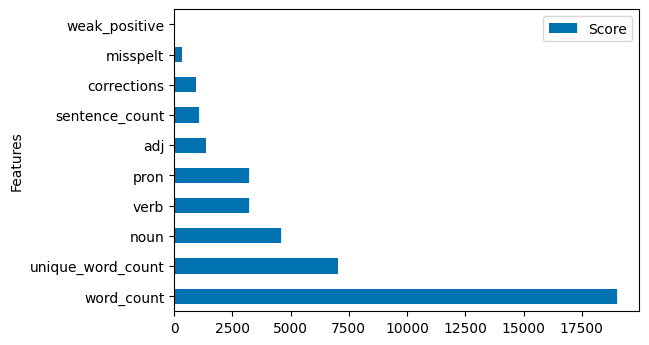

In [184]:
df_score=pd.DataFrame(fit.scores_)
dfcolumns=pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,df_score],axis=1)
featureScores.columns=['Features','Score']
featureScores=featureScores.set_index('Features')
featureScores.nlargest(10,'Score').plot(kind='barh')
plt.show()

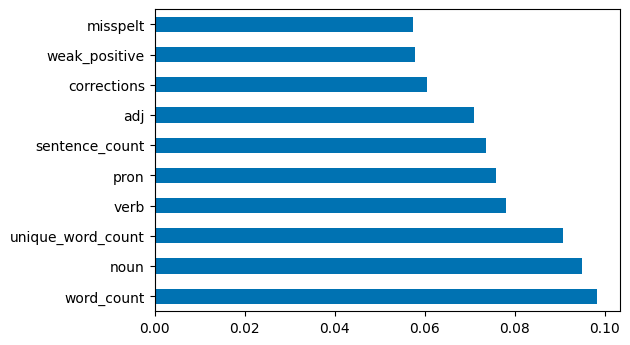

In [185]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)

feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [186]:
training_set.shape

(425, 26)

In [188]:
selector = SelectKBest(f_regression, k=9) 


df = pd.DataFrame()
topics = [1,3,4,5,6,7]
for topic in topics:
    kpredictors = []
    
    
    for p in features:
        if np.std(training_set[training_set.topic == topic][p], axis=0) != 0:
            kpredictors.append(p)
            
    
    X = training_set[training_set.topic == topic][kpredictors]
    y = training_set[training_set.topic == topic].target_score
    
    selector.fit(X, y)

    
    mask = selector.get_support(indices=True)

    selected_features = training_set[training_set.topic == topic][features].columns[mask]
    df["Topic " + str(topic)] = selected_features
df

,Topic 1,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7
0,word_count,corrections,misspelt,word_count,word_count,corrections
1,sentence_count,misspelt,word_count,sentence_count,sentence_count,misspelt
2,unique_word_count,word_count,sentence_count,unique_word_count,unique_word_count,word_count
3,noun,sentence_count,unique_word_count,noun,noun,sentence_count
4,adj,unique_word_count,noun,adj,adj,unique_word_count
5,pron,noun,adj,pron,verb,noun
6,verb,adj,pron,verb,strong_negative,adj
7,strong_negative,pron,verb,strong_positive,strong_both,pron
8,weak_negative,verb,strong_negative,strong_both,weak_positive,verb


#### kappa score


In [189]:
def evaluate(df, topic, features, model):
    """Regression pipeline with kappa evaluation"""

    X = df[df['topic'] == topic][features]
    y = df[df['topic'] == topic]['target_score'].astype(np.float64)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=26)
    
    model.fit(X_train, y_train)    
    y_pred = model.predict(X_test)

    return quadratic_weighted_kappa(y_pred, y_test)

##### funcs


In [190]:
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings

def quadratic_weighted_kappa(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Calculates the quadratic weighted kappa
    quadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return 1.0 - numerator / denominator

# Taken From https://github.com/NishantSushmakar/Automated-Essay-Grading

#### model

In [191]:
model = LinearRegression()

In [192]:
# ALL FEATURES KAPPA VALUES PER ESSAYSET
essaysets = [1,3,4,5,6,7]

# for steps in models:
kappas = []
weights = []
for essayset in essaysets:
    kappas.append(evaluate(training_set, essayset, features, model))
    # weights.append(len(training_set[training_set.topic==essayset]))

print(kappas)


[0.8863109048723897, 0.45210727969348663, 0.3414634146341463, 0.5781710914454278, 0.46630727762803215, 0.5791027496382053]


In [193]:
langFeatures = ['word_count', 'sentence_count', 'unique_word_count' ]
speechFeatures = ['noun', 'adj', 'pron', 'verb']
orthoFeatures = ['corrections',  'misspelt']
emotiveFeatures = ['strong_positive', 'strong_negative', 'strong_neutral', 'strong_both', 'weak_positive', 'weak_negative', 'weak_neutral', 'weak_both']



In [165]:
# SPECIFIC FEATURES KAPPA VALUES PER ESSAYSET
# draw graph
essaysets = [1,3,4,5,6,7]

kappas1 = []
kappas2 = []
kappas3 = []
kappas4 = []

weights = []
for essayset in essaysets:
    kappas1.append(evaluate(training_set, essayset, langFeatures, model))
    kappas2.append(evaluate(training_set, essayset, speechFeatures, model))
    kappas3.append(evaluate(training_set, essayset, corrFeatures, model))
    kappas4.append(evaluate(training_set, essayset, emotiveFeatures, model))

print('langFeatures', kappas1)
print('partsofspeechFeatures', kappas2)
print('orthoFeatures',kappas3)
print('emotiveFeatures', kappas4)

# languageFluency, PartsOfSpeech, Orthography, Subjective

langFeatures [0.9006309148264984, 0.502262443438914, 0.5573440643863179, 0.5352112676056338, 0.21739130434782616, 0.6296326201049656]
partsofspeechFeatures [0.8842105263157894, 0.502262443438914, 0.4488517745302716, 0.5352112676056339, 0.5652173913043479, 0.4925019731649566]
orthoFeatures [-0.00517464424320857, 0.3390557939914163, 0.326039387308534, 0.0, 0.0, 0.29020394516883974]
emotiveFeatures [-0.16666666666666652, -0.18326693227091595, 0.42105263157894735, 0.2978723404255319, 0.50561797752809, -0.09980738924881893]


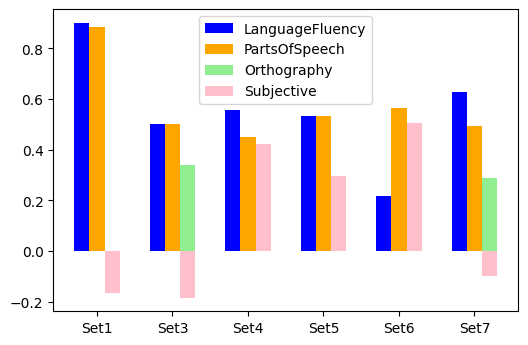

In [194]:
import matplotlib.pyplot as plt
import numpy as np

# langFeatures 
# speechFeatures 
# corrFeatures 
# emotiveFeatures 

x = np.arange(6)
y1 = kappas1
y2 = kappas2
y3 = kappas3
y4 = kappas4
width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, y1, width, color='blue')
plt.bar(x, y2, width, color='orange')
plt.bar(x+0.2, y3, width, color='lightgreen')
plt.bar(x+0.2, y4, width, color='pink')
plt.xticks(x, ['Set1', 'Set3', 'Set4', 'Set5', 'Set6', 'Set7'])

plt.legend(["LanguageFluency", "PartsOfSpeech", "Orthography", "Subjective"])
plt.show()